<a href="https://colab.research.google.com/github/anishjohnson/Airbnb-Booking-Analysis/blob/main/Appliances_Energy_Prediction_Anish_Johnson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Appliances Energy Prediction**

## **Problem Description:**
### Our task is to build a model that predicts the energy use of appliances using the given data that includes energy used by appliances (dependent variable) and light fixtures in house, temperature and humidity of different rooms, date-time, outside temperature and humidity, visibility, twepoint and two random variables.

## **Data Set Information:**
### The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

### **Dependent variable:**
* Appliances : energy use in Wh

### **Independent variables:**
* date : date time year-month-day hour:minute:second
* lights : energy use of light fixtures in the house in Wh
* T1 :  Temperature in kitchen area, in Celsius
* RH_1 : Humidity in kitchen area, in %
* T2 :  Temperature in living room area, in Celsius
* RH_2 : Humidity in living room area, in %
* T3 : Temperature in laundry room area
* RH_3 : Humidity in laundry room area, in %
* T4 : Temperature in office room, in Celsius
* RH_4 : Humidity in office room, in %
* T5 : Temperature in bathroom, in Celsius
* RH_5 : Humidity in bathroom, in %
* T6 : Temperature outside the building (north side), in Celsius
* RH_6 : Humidity outside the building (north side), in %
* T7 : Temperature in ironing room , in Celsius
* RH_7 : Humidity in ironing room, in %
* T8 : Temperature in teenager room 2, in Celsius
* RH_8 : Humidity in teenager room 2, in %
* T9 : Temperature in parents room, in Celsius
* RH_9 : Humidity in parents room, in %
* T_out : Temperature outside (from Chievres weather station), in Celsius
* Press_mm_hg : Pressure (from Chievres weather station), in mm Hg
* RH_out : RH_out, Humidity outside (from Chievres weather station), in %
* Windspeed : Wind speed (from Chievres weather station), in m/s
* Visibility : Visibility (from Chievres weather station), in km
* Tdewpoint : Tdewpoint (from Chievres weather station), Â°C
* rv1 : Random variable 1, nondimensional
* rv2 :  Random variable 2, nondimensional

# **Import libraries and data:**

In [64]:
# import the libraries.

import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [65]:
# Mount the drive.
from google.colab import drive
drive.mount('/content/drive')

# Load the data.
energy_df = pd.read_csv('/content/drive/MyDrive/Appliances Energy Prediction - Anish Johnson/Copy of data_application_energy.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Exploratory Data Analysis:**

### **First look:**

In [66]:
# First look at the data.
energy_df.head(2)

date  Appliances  lights  ...  Tdewpoint        rv1        rv2
0  2016-01-11 17:00:00          60      30  ...        5.3  13.275433  13.275433
1  2016-01-11 17:10:00          60      30  ...        5.2  18.606195  18.606195

[2 rows x 29 columns]

In [67]:
energy_df.tail(2)

date  Appliances  lights  ...  Tdewpoint        rv1        rv2
19733  2016-05-27 17:50:00         420      10  ...  13.233333   6.322784   6.322784
19734  2016-05-27 18:00:00         430      10  ...  13.200000  34.118851  34.118851

[2 rows x 29 columns]

In [68]:
# Before we go any further lets rename the columns for better understsnding.
# Create dict with all new names.
rename_dict = {'Appliances':'Appliances_energy', 'lights':'lights_energy', 'T1':'T_kitchen', 'RH_1':'RH_kitchen', 'T2':'T_livingroom', 'RH_2':'RH_livingroom',
               'T3':'T_laundryroom', 'RH_3':'RH_laundryroom', 'T4':'T_officeroom', 'RH_4':'RH_officeroom', 'T5':'T_bathroom', 'RH_5':'RH_bathroom', 'T6':'T_OutsideBuliding',
               'RH_6':'RH_OutsideBuilding', 'T7':'T_ironingroom', 'RH_7':'RH_ironingroom', 'T8':'T_teenagerroom2', 'RH_8':'RH_teenagerroom2', 'T9':'T_parentsroom', 'RH_9':'RH_parentsroom'}

energy_df.rename(columns=rename_dict, inplace=True)


In [69]:
# Shape of our data.
shape = energy_df.shape
print(f'The dataset contains {shape[0]} rows and {shape[1]} columns.')

The dataset contains 19735 rows and 29 columns.


In [70]:
# Get some info anout the data.
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                19735 non-null  object 
 1   Appliances_energy   19735 non-null  int64  
 2   lights_energy       19735 non-null  int64  
 3   T_kitchen           19735 non-null  float64
 4   RH_kitchen          19735 non-null  float64
 5   T_livingroom        19735 non-null  float64
 6   RH_livingroom       19735 non-null  float64
 7   T_laundryroom       19735 non-null  float64
 8   RH_laundryroom      19735 non-null  float64
 9   T_officeroom        19735 non-null  float64
 10  RH_officeroom       19735 non-null  float64
 11  T_bathroom          19735 non-null  float64
 12  RH_bathroom         19735 non-null  float64
 13  T_OutsideBuliding   19735 non-null  float64
 14  RH_OutsideBuilding  19735 non-null  float64
 15  T_ironingroom       19735 non-null  float64
 16  RH_i

* ***date needs to be converted to datetime format.***

In [71]:
# Convetrt date to correct format.
energy_df['date'] = pd.to_datetime(energy_df['date'])

# Extract day and month details from date, we do not take year details as it is constant 2016.
energy_df['day'] = energy_df.date.dt.weekday
energy_df['month'] = energy_df.date.dt.month

# Extract time details from date.
energy_df['time'] = energy_df.date.dt.hour

In [72]:
# Since we have extracted the datetime values lets drop the date feature.
energy_df.drop('date', axis=1, inplace=True)

In [73]:
# Check for null values.
energy_df.isnull().sum()

Appliances_energy     0
lights_energy         0
T_kitchen             0
RH_kitchen            0
T_livingroom          0
RH_livingroom         0
T_laundryroom         0
RH_laundryroom        0
T_officeroom          0
RH_officeroom         0
T_bathroom            0
RH_bathroom           0
T_OutsideBuliding     0
RH_OutsideBuilding    0
T_ironingroom         0
RH_ironingroom        0
T_teenagerroom2       0
RH_teenagerroom2      0
T_parentsroom         0
RH_parentsroom        0
T_out                 0
Press_mm_hg           0
RH_out                0
Windspeed             0
Visibility            0
Tdewpoint             0
rv1                   0
rv2                   0
day                   0
month                 0
time                  0
dtype: int64

In [74]:
# What do the statistics about the data tell?
energy_df.describe()

Appliances_energy  lights_energy  ...         month          time
count       19735.000000   19735.000000  ...  19735.000000  19735.000000
mean           97.694958       3.801875  ...      3.101647     11.502002
std           102.524891       7.935988  ...      1.339200      6.921953
min            10.000000       0.000000  ...      1.000000      0.000000
25%            50.000000       0.000000  ...      2.000000      6.000000
50%            60.000000       0.000000  ...      3.000000     12.000000
75%           100.000000       0.000000  ...      4.000000     17.000000
max          1080.000000      70.000000  ...      5.000000     23.000000

[8 rows x 31 columns]

***Points to be noted:***
* *Appliances show presence of few outliers.*
* *lights has to be dropped.*
* *day consists of total 7 values, which justify the 7 days in a week.*
* *only the first 5 months are reccorded in the data.*
* *year is a constant values, it justifies the fact that the is of year 2016, it will be dropped.*
* *time consists 24 values indicating the 24 hrs in a day.*

In [75]:
energy_df.drop('lights_energy', axis=1, inplace=True)

### **Dependent Variable - Appliances_energy:**





In [76]:
# fivethirtyeight,ggplot,tableau-colorblind10

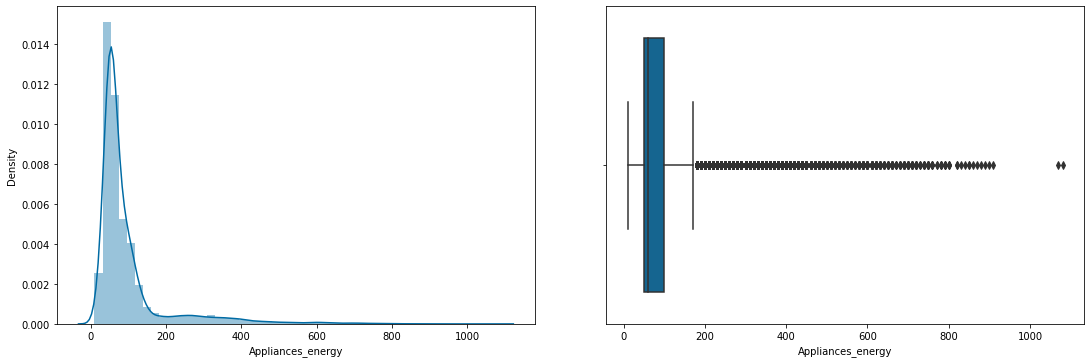

In [77]:
# Start with the dependent variable.
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.tight_layout(h_pad=4, w_pad=4)
sns.distplot(energy_df['Appliances_energy'], ax=ax[0])
sns.boxplot(energy_df['Appliances_energy'], ax=ax[1])
plt.show()

**Points to be noted:**
* Appliances_energy is positively skewed, we had already seen that 75% of the values are 100. 
* The boxplots also shows most of the values are less than 200.
* Extreme values are present after 1000 which should be removed.

In [78]:
# lets check the values greater than 1000.
energy_df[energy_df['Appliances_energy'] > 1000]

Appliances_energy  T_kitchen  RH_kitchen  ...  day  month  time
731                1080      21.93   42.766667  ...    5      1    18
1451               1070      19.60   34.300000  ...    3      1    18

[2 rows x 30 columns]

In [79]:
# Remove the extreme values.
energy_df = energy_df[energy_df['Appliances_energy'] < 1000]

## **Independent Variables:**

In [81]:
# # Create new dataframes for house_temperatures, humidity, outside_weather and rest of the features.

# # house_temperature.
# house_temperature = pd.DataFrame(data=energy_df, columns=['T_kitchen', 'T_livingroom', 'T_laundryroom', 'T_officeroom',
#                                                           'T_bathroom', 'T_ironingroom', 'T_teenagerroom2', 'T_parentsroom'])
# # humidity.
# humidity = pd.DataFrame(data=energy_df, columns=['RH_kitchen', 'RH_livingroom', 'RH_laundryroom', 'RH_officeroom',
#                                                  'RH_bathroom', 'RH_ironingroom', 'RH_teenagerroom2', 'RH_parentsroom'])
# # outside_weather.
# outside_weather = pd.DataFrame(data=energy_df, columns=['T_OutsideBuliding', 'RH_OutsideBuilding', 'T_out', 'RH_out', 'Press_mm_hg', 'Windspeed', 'Visibility', 'Tdewpoint'])

# # datetime_features.
# datetime_features = pd.DataFrame(data=energy_df, columns=['day','month', 'time'])

# # random_features.
# random_features = pd.DataFrame(data=energy_df, columns=['rv1', 'rv2'])

# # Final df
# df_sorted = 

In [82]:
energy_df2 = energy_df.reindex(columns=['Appliances_energy', 'T_kitchen', 'T_livingroom', 'T_laundryroom', 'T_officeroom',
                                        'T_bathroom', 'T_ironingroom', 'T_teenagerroom2', 'T_parentsroom', 'RH_kitchen',
                                        'RH_livingroom', 'RH_laundryroom', 'RH_officeroom', 'RH_bathroom', 'RH_ironingroom',
                                        'RH_teenagerroom2', 'RH_parentsroom', 'T_OutsideBuliding', 'RH_OutsideBuilding',
                                        'T_out', 'RH_out', 'Press_mm_hg', 'Windspeed', 'Visibility', 'Tdewpoint', 'day',
                                        'month', 'time', 'rv1', 'rv2'])

In [83]:
energy_df2.head(1)

Appliances_energy  T_kitchen  T_livingroom  ...  time        rv1        rv2
0                 60      19.89          19.2  ...    17  13.275433  13.275433

[1 rows x 30 columns]

### **Temperatures and Appliances_energy:**

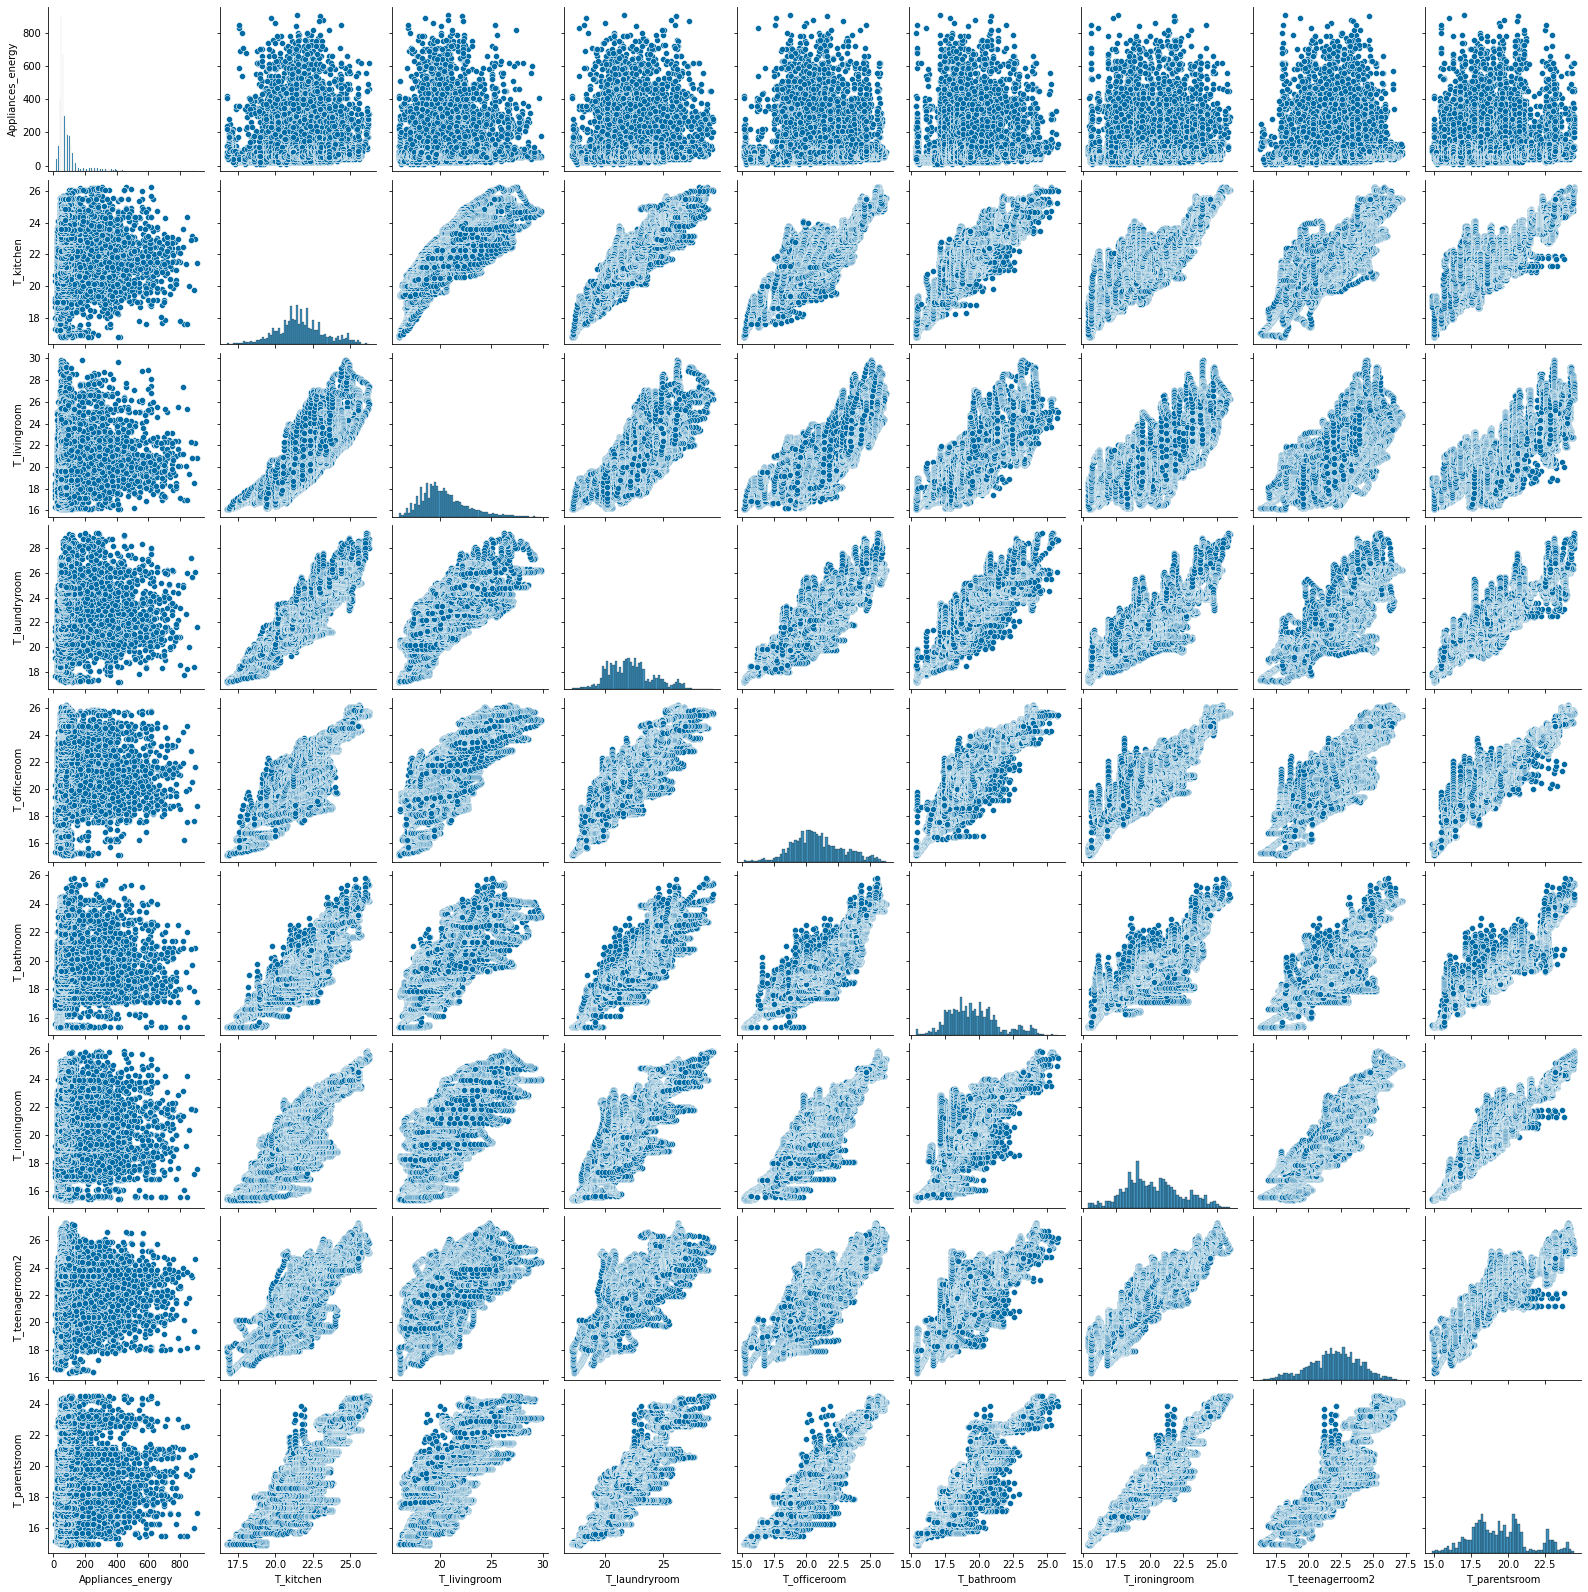

In [84]:
# Relation between Temperatures and Appliances_energy
df1 = energy_df2.iloc[:, :9]
sns.pairplot(df1)
plt.show()

**Points to be noted:**
* All of the temperature values are more related to each other than the dependent variable. Which means all of the temperature values are related to each other.
* Temperature values seem normally distributed.


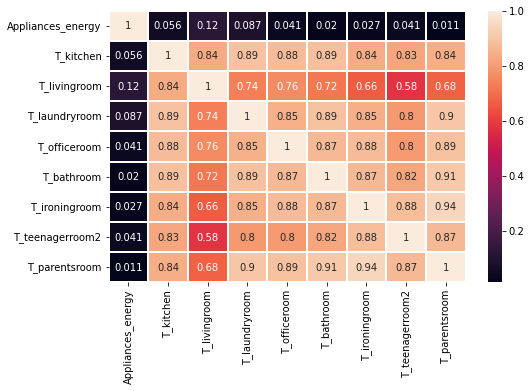

In [85]:
# Correlation between the temperatures and Appliances_energy.
fig = plt.figure(figsize=(8,5))
sns.heatmap(df1.corr(), annot=True, linewidth=1)
plt.show()

**Points to be noted:**
* As we had seen all the temperature values are highly correlated with each other rather than the dependent variable. 
* The highest correlation with Appliances_energy is 0.12 which is between the livingroom temperature.

**Temperature throughuot the months, days and time:**

In [86]:
# Create a column for the average house temperature (inside).
energy_df2['avg_house_temp'] = energy_df2.iloc[:, 1:9].mean(axis=1)

In [87]:
energy_df2.head()

Appliances_energy  T_kitchen  ...        rv2  avg_house_temp
0                 60      19.89  ...  13.275433       18.435000
1                 60      19.89  ...  18.606195       18.439167
2                 50      19.89  ...  28.642668       18.421667
3                 50      19.89  ...  45.410389       18.396250
4                 60      19.89  ...  10.084097       18.408750

[5 rows x 31 columns]

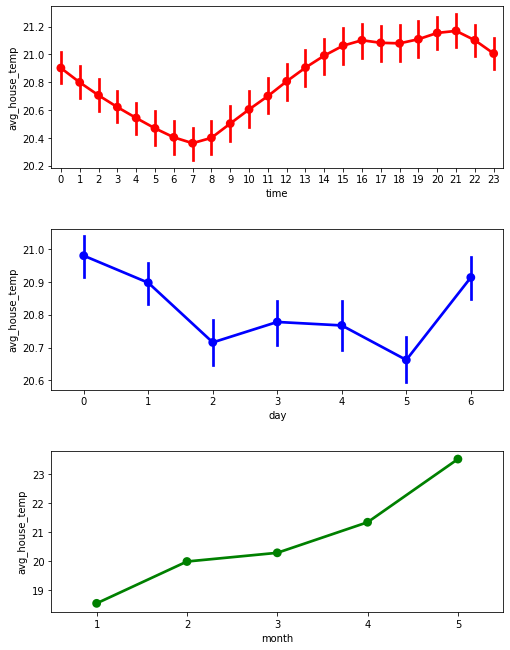

In [88]:
# Temperature throughout the time, day and months.
fig, ax = plt.subplots( nrows=3, ncols=1, figsize=(7,9))
fig.tight_layout(h_pad=4, w_pad=4)
sns.pointplot(energy_df2['time'], energy_df2['avg_house_temp'], color='red', ax=ax[0])
sns.pointplot(energy_df2['day'], energy_df2['avg_house_temp'], color='blue', ax=ax[1])
sns.pointplot(energy_df2['month'], energy_df2['avg_house_temp'], color='green', ax=ax[2])
plt.show()


**Points to be noted:**
* The average temperature of the house decreases duirng the midnight and gradually increases after 6am, this makes sense as most of the people are sleeping during the midnights and wakeup by 6am.
* Average temperature is higher on mondays, tuesdays and sundays.
* Average temperature rises after the first month and reaches its peak in the fifth month, this makes sense as the fifth month is May and its summer time.

### **Humidity and Appliances_energy:**



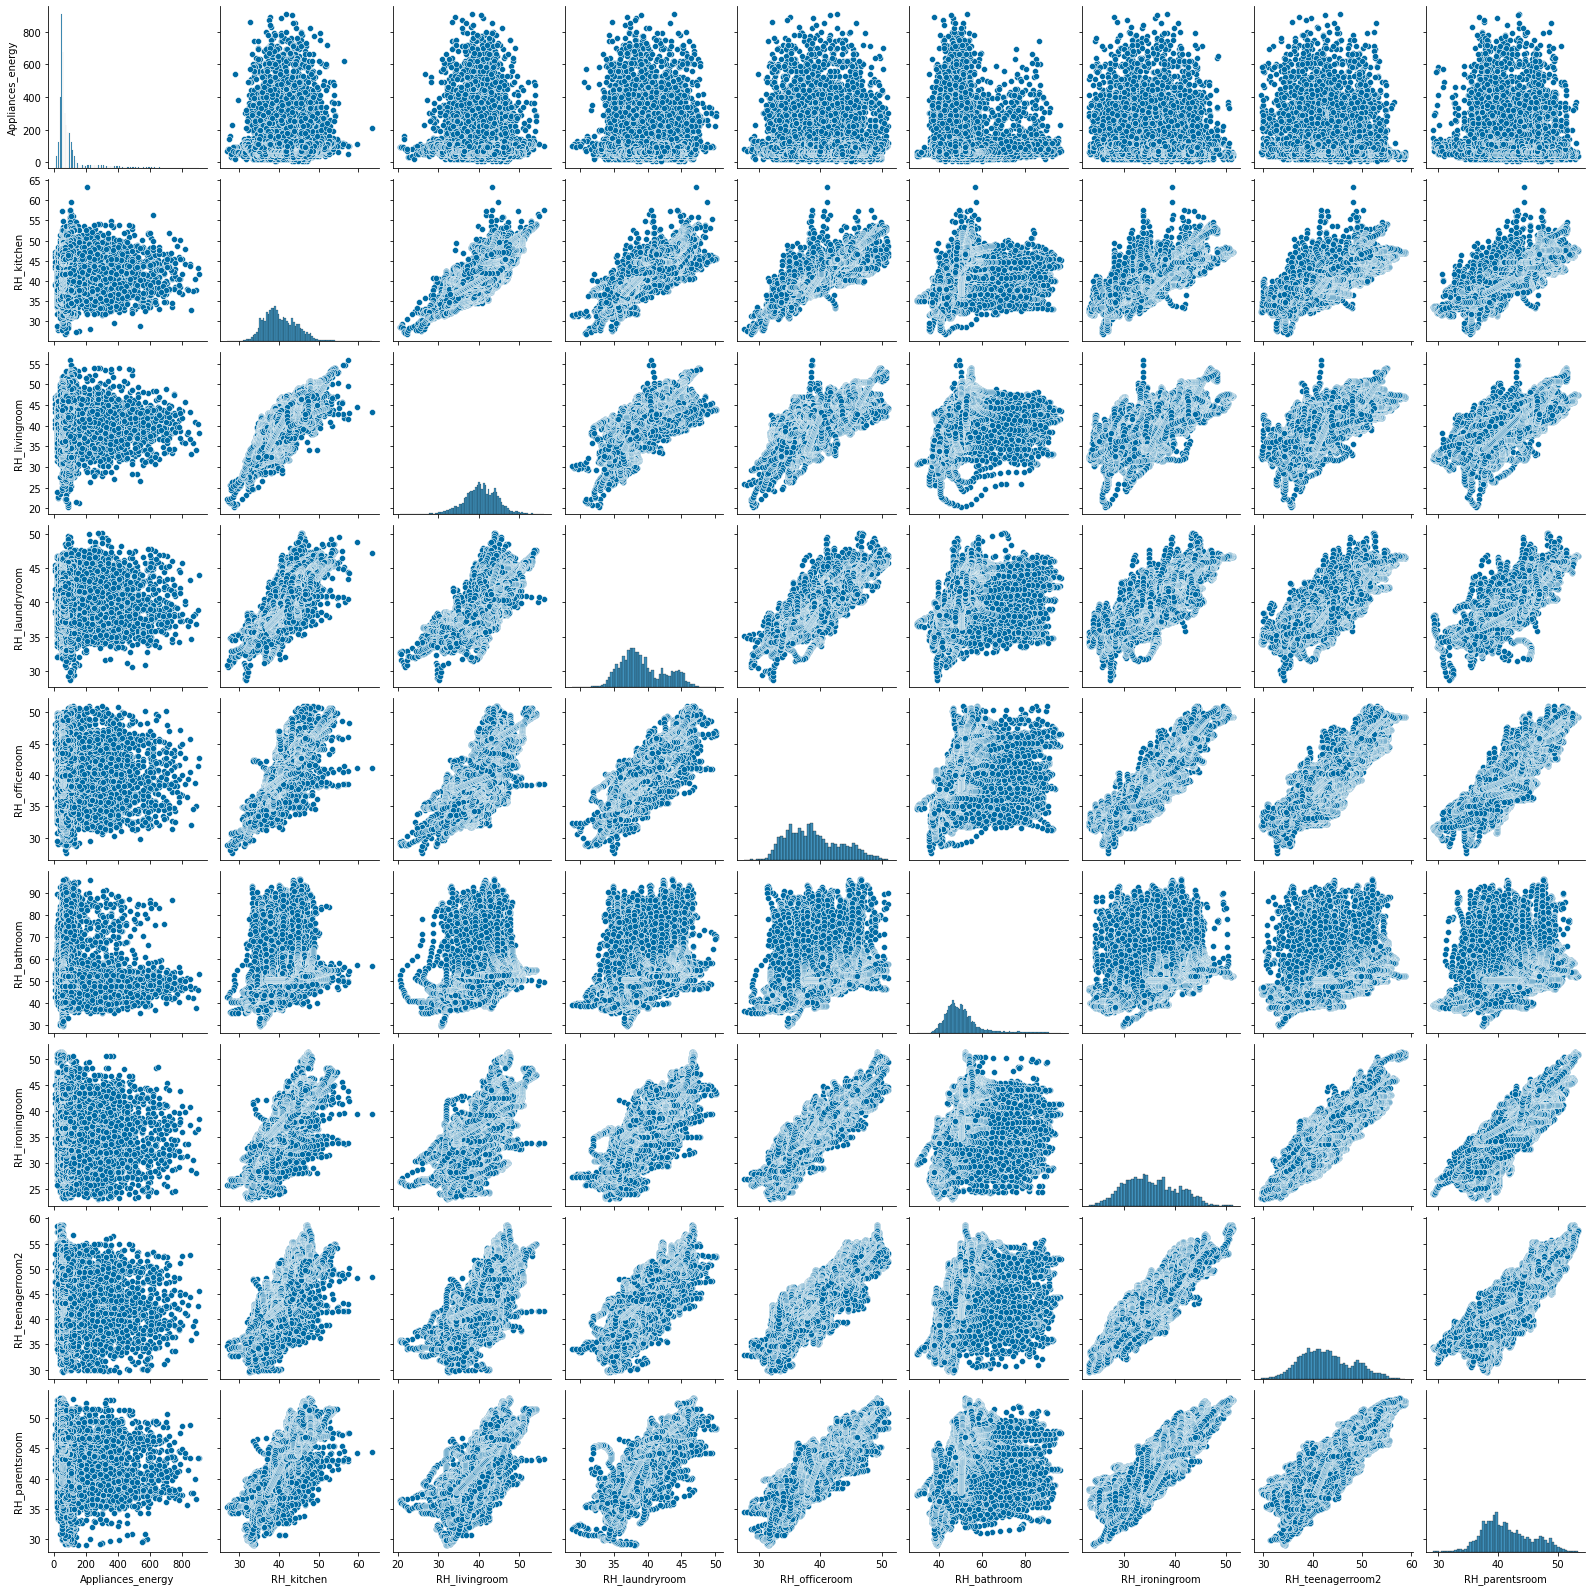

In [93]:
# Relation between Temperatures and Appliances_energy
df2 = energy_df2.loc[:, ['Appliances_energy', 'RH_kitchen', 'RH_livingroom', 'RH_laundryroom', 'RH_officeroom',
                                  'RH_bathroom', 'RH_ironingroom', 'RH_teenagerroom2', 'RH_parentsroom']]
sns.pairplot(df2)
plt.show()

**Points to be noted:**
* Same as the temperatures, humidity is also correlated to each other rather than the dependent variable.
* Humidity in bathroom is bit different, it makes sense as people use a lot of water in bathrooms due to which the temperature keeps on chaniging as well as the humidity.
* Humidity values seem normally distributed.

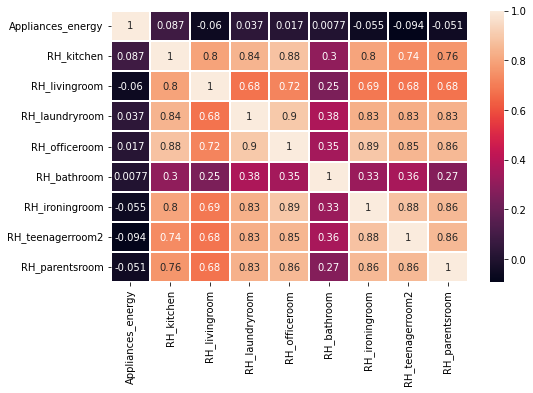

In [94]:
# Correlation between the humidity and Appliances_energy.
fig = plt.figure(figsize=(8,5))
sns.heatmap(df2.corr(), annot=True, linewidth=1)
plt.show()

**Points to be noted:**
* As seen before humidity values are correlated among themselves.

In [95]:
# Create a column for the average house humidity (inside).
energy_df2['avg_house_humidity'] = energy_df2.iloc[:, 9:17].mean(axis=1)

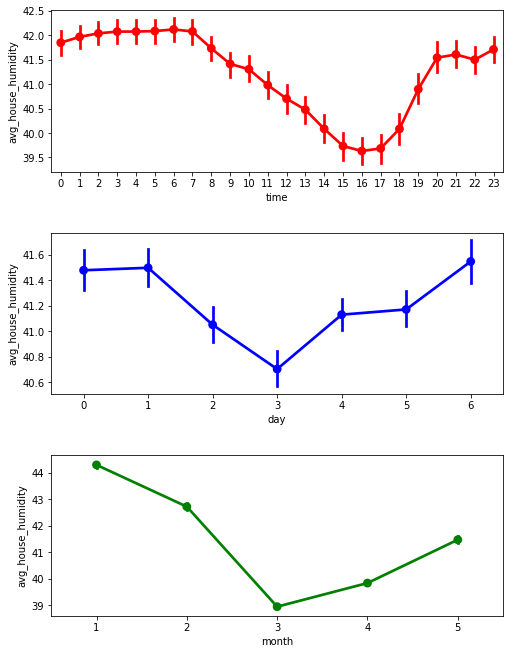

In [96]:
# Humidity throughout the time, day and months.
fig, ax = plt.subplots( nrows=3, ncols=1, figsize=(7,9))
fig.tight_layout(h_pad=4, w_pad=4)
sns.pointplot(energy_df2['time'], energy_df2['avg_house_humidity'], color='red', ax=ax[0])
sns.pointplot(energy_df2['day'], energy_df2['avg_house_humidity'], color='blue', ax=ax[1])
sns.pointplot(energy_df2['month'], energy_df2['avg_house_humidity'], color='green', ax=ax[2])
plt.show()